In [1]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC

# Dataset
df = pd.read_excel('Telco_dataset.xlsx')

Before creating interaction terms to use in testing, there are a few housekeeping tasks that need done. I first dropped the columns in the dataset that would not be utilized in model development. I then filled in the NaN values for the variables, 'Total Charges' and 'Total Revenue', and converted Total Charges into its correct data type - numeric. After that, as per my initial feature testing done in my EDA, I created variables for the natural log of 'Total Revenue', 'Total Charges', and 'Monthly Charges', to test their predictive power with the algorithms.

In [2]:
# Dropping columns that will not be used for model building
df = df.drop(columns=['CustomerID', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Churn Label', 'Churn Score', 'Churn Reason', 
                      'Churn Category', 'Customer Status', 'Satisfaction Score'])

# Fixing NaN's for Total Revenue and Total Charges, and converting Total Charges to numeric from type object
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce') 
df['Total Charges'] = df['Total Charges'].fillna(df['Total Charges'].mean())
df['Total Revenue'] = df['Total Revenue'].fillna(df['Total Revenue'].mean())

# Creating variables for the natrual logs of Total Revenue, Total Charges and Monthly Charges
df['Log_Total_Revenue'] = np.log1p(df['Total Revenue'])
df['Log_Total_Charges'] = np.log1p(df['Total Charges'])
df['Log_Monthly_Charges'] = np.log1p(df['Monthly Charges'])

Next, I will be defining the categorical and numerical columns in the dataset. This is done for two purposes. The first, is in order to make creating interaction terms between the two lists of variables easier. The second will be for later, when I apply SMOTENC to the dataset, in order to define which columns are categorical.

In [3]:
# Defining categorical columns
original_categorical_columns = ['Gender', 'Senior Citizen', 'Offer', 'Payment Method', 'Contract', 'Premium Tech Support', 'Online Security', 
                                'Internet Service', 'Dependents', 'Unlimited Data', 'Streaming Movies', 'Streaming TV', 'Referred a Friend', 
                                'Paperless Billing', 'Device Protection', 'Online Backup', 'Partner', 'Phone Service', 'Multiple Lines',
                                'Streaming Music']

# Defining target variable column
target_column = 'Churn Value'

# Defining numerical columns based on the list of categorical ones
original_numeric_columns = [col for col in df.columns if col not in original_categorical_columns + [target_column]]

To create interaction features for testing, I have created a method, "create_interaction_features", that takes in the two lists of variables, and creates interaction terms amongst the categorical variables, and between the categorical and numerical variables. These new variables are added into the dataset for utilization for the algorithms. Initially during EDA, I had experimented with several interaction terms, however, to try and find any additional predictive power from this dataset, this method has been created in order to get the most out of the information available. 

In [6]:
def create_interaction_features(df, categorical_columns, numeric_columns):
    df = df.copy()
    new_features = []

    # Interaction amongst categorical variables
    for i, cat1 in enumerate(categorical_columns):
        for cat2 in categorical_columns[i+1:]:
            interaction_col = f'Interaction_{cat1}_{cat2}'
            df[interaction_col] = df[cat1].astype(str) + "_" + df[cat2].astype(str)
            new_features.append(interaction_col)

    # Interaction between categorical and numeric variables
    for cat in categorical_columns:
        for num in numeric_columns:
            interaction_col = f'Interaction_{cat}_{num}'
            df[interaction_col] = df[num].astype(str) + "_" + df[cat].astype(str)
            new_features.append(interaction_col)

    return df, new_features

df, interaction_features = create_interaction_features(df, original_categorical_columns, original_numeric_columns)
categorical_columns = original_categorical_columns + interaction_features
numeric_columns = original_numeric_columns

C:\Users\kconv\AppData\Local\Temp\ipykernel_17956\801767860.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[interaction_col] = df[cat1].astype(str) + "_" + df[cat2].astype(str)
C:\Users\kconv\AppData\Local\Temp\ipykernel_17956\801767860.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[interaction_col] = df[cat1].astype(str) + "_" + df[cat2].astype(str)
C:\Users\kconv\AppData\Local\Temp\ipykernel_17956\801767860.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Now that the interaction terms have been created, I will define my X and y, and split my data into training and testing, opting for a 80/20 train-test split instead of a 70-30 due to the size of the dataset. Y will be stratified, as the dataset has a heavy imbalance of non-churners (0) over churners (1). This will help ensure that the models I test learn and generalize well on the test data. Also, the indices of the categorical variables will be defined here for SMOTENC later on.

In [5]:
# Feature variables
X = df.drop(columns=target_column)

# Target variable
y = df[target_column]

# Defining categorical variable index locations for SMOTENC later
#categorical_indices = [X.columns.get_loc(col) for col in categorical_columns]
categorical_indices = [X.columns.get_loc(col) for col in original_categorical_columns]

# Splitting data into train-test, using an 80/20 split and stratifying y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

The variables in my dataset will go through two different preprocessing transformations before they're tested in the models. For categorical variables, I will be using OneHotEncoding to convert the variables over to numerical seamlessly for utilization. For numerical variables, I will be using a StandardScaler. The StandardScaler will reduce the impact of any extreme values present in the numerical columns, giving each column a mean of 0 and a standard deviation of 1 (a standard normal distribution). These two transformers will be fed into a column transformer, that will be put into a pipeline alongside the model(s) I will be testing for repeatability, to reduce redundancy in the code, and to ensure the process is smooth and error free. 

Each of the models I will be testing will go through a 5-fold, cross-validated grid search, in order to determine the best values for each algorithm's hyperparameters. The best values will be determined through average 'recall' scores, my main metric to compare performance. Recall, specifically class 1 recall, will be the most important metric for me in determining if a model will be successful in solving my particular business problem. In the case of this project, False Negatives (predicting a customer will not churn when they actually do) will be more costly than False Positives (predicting a customer will churn when they actually don't). Therefore, my model of choice can afford to have tradeoff in class 1 precision in order to have better class 1 recall, up to a point. 

The first of the models I will be testing is Logistic Regression. 

In [18]:
# One Hot Encoding for categorical variables
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Standard Scaler for numerical variables
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        #('num', numeric_transformer, numeric_columns),
        ('num', numeric_transformer, original_numeric_columns),
        #('cat', categorical_transformer, categorical_columns)
        ('cat', categorical_transformer, original_categorical_columns)
    ]
)

model = LogisticRegression(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

param_grid = {
    'classifier__solver': ['liblinear', 'sag', 'saga'],
    'classifier__max_iter': [62],
    'classifier__C': [.005, .01, .05]    
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='recall',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Tenure '
                                                                          'Months',
                                                                          'Monthly '
                                                                          'Charges',
                                                                          'Total '
                                                                          'Charges',
                                                                          'CLTV',
                                                                          'Number '
                                                                          'of '
                                                                          'Dependents',
                                                                          'Age',
                                                                          'Number '
                                                                          'of '
                                                                          'Referrals',
                                                                          'Avg '
                                                                          'Monthly '
                                                                          'Long '
                                                                          'Distance '
                                                                          'Charges',
                                                                          'Avg '
                                                                          'Monthly '
                                                                          'GB '
                                                                          'Download',
                                                                          'Total '
                                                                          'Refunds',
                                                                          'Total '
                                                                          'Extra '
                                                                          'Data '
                                                                          'Charges',
                                                                          'T...
                                                                          'Friend',
                                                                          'Paperless '
                                                                          'Billing',
                                                                          'Device '
                                                                          'Protection',
                                                                          'Online '
                                                                          'Backup',
                                                                          'Partner',
                                                                          'Phone '
                                                                          'Service',
                                                                          'Multiple '
                                                                          'Lines',
                                                                          'Streaming '
                                                                          'Music'])])),
                                       ('classifier',
   

In [19]:
print(f"\n Best parameters: {grid_search.best_params_}")
print(f" Best cross-validated score (recall): {grid_search.best_score_:.4f}")
cv_results = pd.DataFrame(grid_search.cv_results_)
print(cv_results[['params', 'mean_test_score', 'rank_test_score']])


 Best parameters: {'classifier__C': 0.05, 'classifier__max_iter': 62, 'classifier__solver': 'sag'}
 Best cross-validated score (recall): 0.6221
                                              params  mean_test_score  \
0  {'classifier__C': 0.005, 'classifier__max_iter...         0.559866   
1  {'classifier__C': 0.005, 'classifier__max_iter...         0.551839   
2  {'classifier__C': 0.005, 'classifier__max_iter...         0.551839   
3  {'classifier__C': 0.01, 'classifier__max_iter'...         0.581271   
4  {'classifier__C': 0.01, 'classifier__max_iter'...         0.575920   
5  {'classifier__C': 0.01, 'classifier__max_iter'...         0.575920   
6  {'classifier__C': 0.05, 'classifier__max_iter'...         0.620067   
7  {'classifier__C': 0.05, 'classifier__max_iter'...         0.622074   
8  {'classifier__C': 0.05, 'classifier__max_iter'...         0.622074   

   rank_test_score  
0                7  
1                8  
2                8  
3                4  
4                5 

Now that we have the results of the grid search, they will be plugged into the Logistic Regression model through the pipeline in order to check metrics. 

In [20]:
model = LogisticRegression(C=0.05, solver='sag', max_iter=62, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges', 'CLTV',
                                                   'Number of Dependents',
                                                   'Age', 'Number of Referrals',
                                                   'Avg Monthly Long Distance '
                                                   'Charges',
                                                   'Avg Monthly GB Download',
                                                   'Total Refunds',
                                                   'Total Extra Data Charges',
                                                   'Total Long Distance '
                                                   'Charges',
                                                   'Total Revenue',
                                                   'Log_Total_Revenue',...
                                                   'Offer', 'Payment Method',
                                                   'Contract',
                                                   'Premium Tech Support',
                                                   'Online Security',
                                                   'Internet Service',
                                                   'Dependents',
                                                   'Unlimited Data',
                                                   'Streaming Movies',
                                                   'Streaming TV',
                                                   'Referred a Friend',
                                                   'Paperless Billing',
                                                   'Device Protection',
                                                   'Online Backup', 'Partner',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Streaming Music'])])),
                ('classifier',
                 LogisticRegression(C=0.05, max_iter=62, random_state=42,
                                    solver='sag'))])

For each model I will be testing, I will be evaluating it through the use of a confusion matrix. The confusion matrix will be looked at to determine how the models are classifying the test data, specifically how many false positives the model is receiving. To determine the optimal threshold for each confusion matrix, I will plot a precision-recall vs threshold graph that will select the threshold with the maximum f1-score, to ensure balance.

In addition to determining and comparing precision, recall, and f1-score amongst the models, I will also be comparing ROC-AUC as well, in order to see how the models are distinguishing between churners and non-churners, regardless of the threshold.

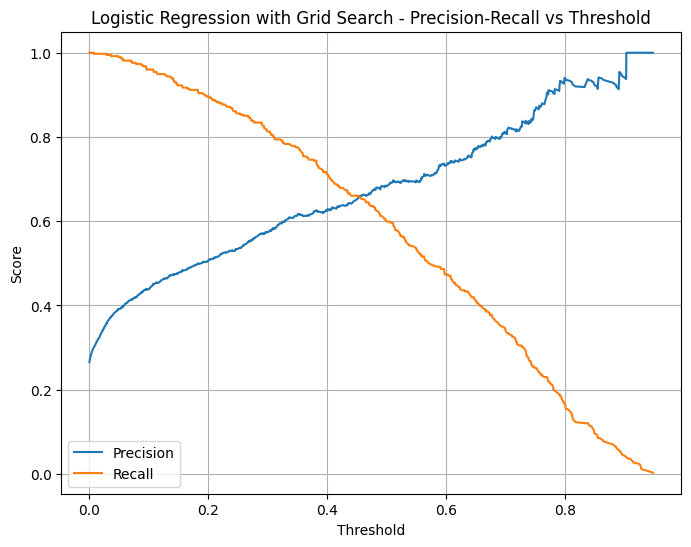


 best threshold (max F1): 0.351

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1035
           1       0.62      0.78      0.69       374

    accuracy                           0.81      1409
   macro avg       0.76      0.80      0.78      1409
weighted avg       0.83      0.81      0.82      1409

ROC-AUC Score: 0.8818


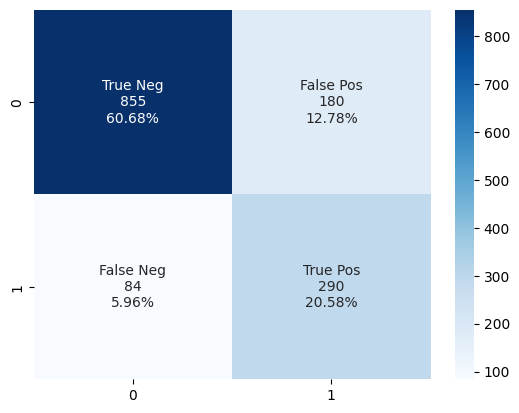

In [21]:
y_prob = pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Logistic Regression with Grid Search - Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Select threshold based on max F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"\n best threshold (max F1): {best_threshold:.3f}")

y_pred = (y_prob >= best_threshold).astype(int)
c_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in c_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]
labels = [f"{g1}\n{g2}\n{g3}" for g1, g2, g3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Based on the results, it shows that the model is finding 85 false negatives, with a class 1 recall of 0.77, class 1 precision of 0.62, and an ROC-AUC of .8848. These are good scores, particularly the ROC-AUC, however, it is possible that we can receive better results with SMOTENC later, as we could potentially find less false negatives. Let's see how it compares to a baseline Logistic Regression.

In [22]:
model = LogisticRegression(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges', 'CLTV',
                                                   'Number of Dependents',
                                                   'Age', 'Number of Referrals',
                                                   'Avg Monthly Long Distance '
                                                   'Charges',
                                                   'Avg Monthly GB Download',
                                                   'Total Refunds',
                                                   'Total Extra Data Charges',
                                                   'Total Long Distance '
                                                   'Charges',
                                                   'Total Revenue',
                                                   'Log_Total_Revenue',...
                                                  ['Gender', 'Senior Citizen',
                                                   'Offer', 'Payment Method',
                                                   'Contract',
                                                   'Premium Tech Support',
                                                   'Online Security',
                                                   'Internet Service',
                                                   'Dependents',
                                                   'Unlimited Data',
                                                   'Streaming Movies',
                                                   'Streaming TV',
                                                   'Referred a Friend',
                                                   'Paperless Billing',
                                                   'Device Protection',
                                                   'Online Backup', 'Partner',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Streaming Music'])])),
                ('classifier', LogisticRegression(random_state=42))])

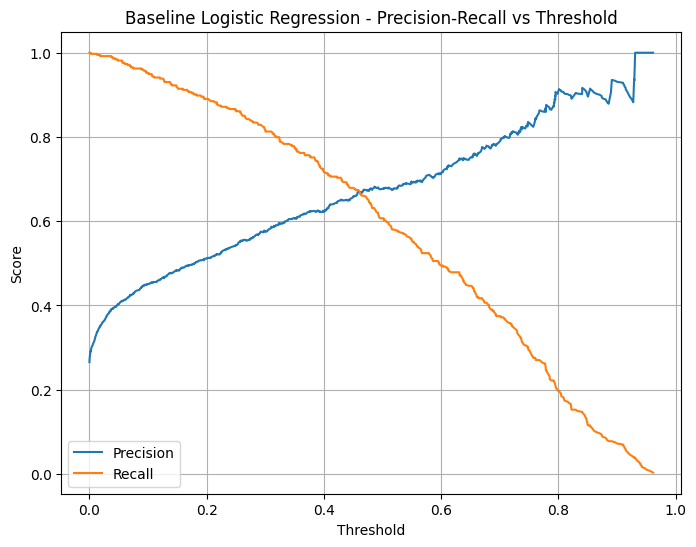


 best threshold (max F1): 0.375

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.87      1035
           1       0.62      0.76      0.68       374

    accuracy                           0.81      1409
   macro avg       0.76      0.80      0.78      1409
weighted avg       0.83      0.81      0.82      1409

ROC-AUC Score: 0.8817


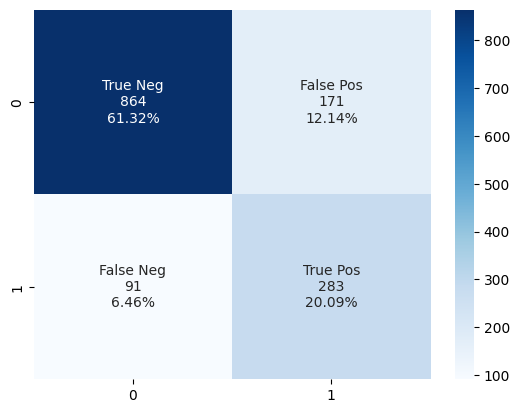

In [24]:
y_prob = pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Baseline Logistic Regression - Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Select threshold based on max F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"\n best threshold (max F1): {best_threshold:.3f}")

y_pred = (y_prob >= best_threshold).astype(int)
c_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in c_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]
labels = [f"{g1}\n{g2}\n{g3}" for g1, g2, g3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Compared to the tuned Logistic Regression, the baseline model performs similarly, obtaining 3 fewer false negatives and 3 greater true positives, however it is at the cost of 20 fewer true negatives and 20 greater false positives. Class 1 recall is slightly greater at 0.78 vs 0.77, and class 1 precision is lesser at 0.60 vs 0.62, as to be expected from the increase in false positives. The ROC-AUC is slightly lower at .8786 vs .8848. The baseline model may have 3 less false negatives, however, I don't believe they're worth it at the cost of 20 more false positives. We'll revisit Logistic Regression later when we apply SMOTE, and for now, will move on to Random Forest.

In [41]:
model = RandomForestClassifier(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

param_grid = {
    'classifier__n_estimators': [93, 94, 95, 96, 105, 110],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth': [15, 16, 17, 18, 19, 20, 21, 22, 23]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='recall',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Tenure '
                                                                          'Months',
                                                                          'Monthly '
                                                                          'Charges',
                                                                          'Total '
                                                                          'Charges',
                                                                          'CLTV',
                                                                          'Number '
                                                                          'of '
                                                                          'Dependents',
                                                                          'Age',
                                                                          'Number '
                                                                          'of '
                                                                          'Referrals',
                                                                          'Avg '
                                                                          'Monthly '
                                                                          'Long '
                                                                          'Distance '
                                                                          'Charges',
                                                                          'Avg '
                                                                          'Monthly '
                                                                          'GB '
                                                                          'Download',
                                                                          'Total '
                                                                          'Refunds',
                                                                          'Total '
                                                                          'Extra '
                                                                          'Data '
                                                                          'Charges',
                                                                          'T...
                                                                          'Protection',
                                                                          'Online '
                                                                          'Backup',
                                                                          'Partner',
                                                                          'Phone '
                                                                          'Service',
                                                                          'Multiple '
                                                                          'Lines',
                                                                          'Streaming '
                                                                          'Music'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy',
                                                   'log_loss'],
                         'classifier__max_depth': [15, 16, 17, 18, 19, 20, 21,
                      

In [42]:
print(f"\n Best parameters: {grid_search.best_params_}")
print(f" Best cross-validated score (recall): {grid_search.best_score_:.4f}")
cv_results = pd.DataFrame(grid_search.cv_results_)
print(cv_results[['params', 'mean_test_score', 'rank_test_score']])


 Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 17, 'classifier__n_estimators': 93}
 Best cross-validated score (recall): 0.5886
                                                params  mean_test_score  \
0    {'classifier__criterion': 'gini', 'classifier_...         0.569900   
1    {'classifier__criterion': 'gini', 'classifier_...         0.569231   
2    {'classifier__criterion': 'gini', 'classifier_...         0.565886   
3    {'classifier__criterion': 'gini', 'classifier_...         0.568562   
4    {'classifier__criterion': 'gini', 'classifier_...         0.567893   
..                                                 ...              ...   
157  {'classifier__criterion': 'log_loss', 'classif...         0.562542   
158  {'classifier__criterion': 'log_loss', 'classif...         0.567893   
159  {'classifier__criterion': 'log_loss', 'classif...         0.560535   
160  {'classifier__criterion': 'log_loss', 'classif...         0.568562   
161  {'classi

In [43]:
model = RandomForestClassifier(n_estimators=93, max_depth=17, criterion='entropy', random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges', 'CLTV',
                                                   'Number of Dependents',
                                                   'Age', 'Number of Referrals',
                                                   'Avg Monthly Long Distance '
                                                   'Charges',
                                                   'Avg Monthly GB Download',
                                                   'Total Refunds',
                                                   'Total Extra Data Charges',
                                                   'Total Long Distance '
                                                   'Charges',
                                                   'Total Revenue',
                                                   'Log_Total_Revenue',...
                                                   'Premium Tech Support',
                                                   'Online Security',
                                                   'Internet Service',
                                                   'Dependents',
                                                   'Unlimited Data',
                                                   'Streaming Movies',
                                                   'Streaming TV',
                                                   'Referred a Friend',
                                                   'Paperless Billing',
                                                   'Device Protection',
                                                   'Online Backup', 'Partner',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Streaming Music'])])),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=17,
                                        n_estimators=93, random_state=42))])

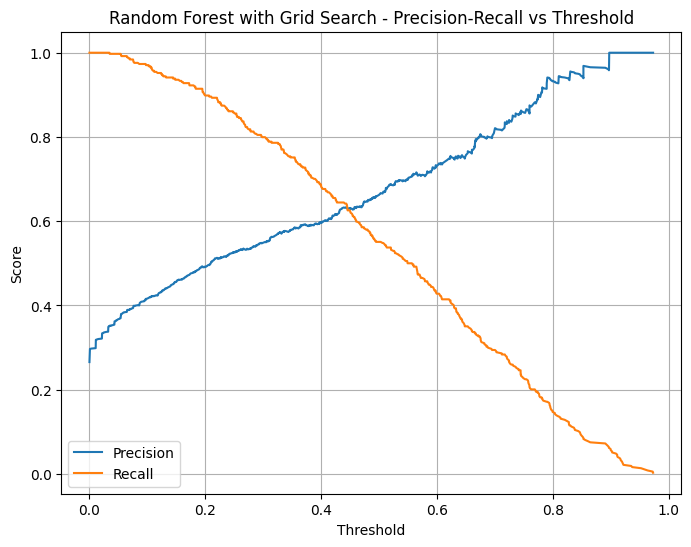


 best threshold (max F1): 0.328

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.79      0.85      1035
           1       0.57      0.78      0.66       374

    accuracy                           0.79      1409
   macro avg       0.74      0.79      0.75      1409
weighted avg       0.82      0.79      0.80      1409

ROC-AUC Score: 0.8701


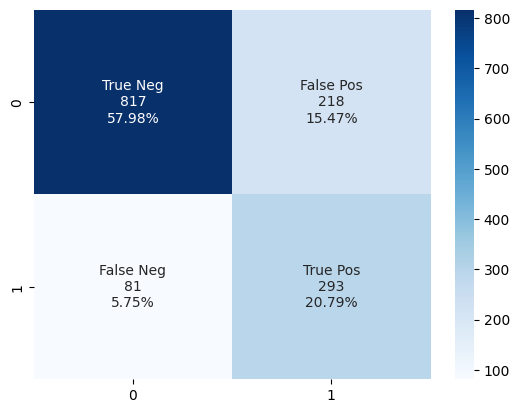

In [44]:
y_prob = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Random Forest with Grid Search - Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Select threshold based on max F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n best threshold (max F1): {best_threshold:.3f}")

y_pred = (y_prob >= best_threshold).astype(int)

c_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in c_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]

labels = [f"{g1}\n{g2}\n{g3}" for g1, g2, g3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Based on the results of the Random Forest, the Logistic Regression model performs better, obtaining 9 fewer false negatives, a lower ROC-AUC score, and lower class 1 recall and precision scores. Additionally, Random Forest is also more computationally expensive than Logistic Regresion, so although Random Forest may be improved with SMOTENC, it definitely performs behind Logistic Regression in its current form. We'll compare this and the tuned Logistic Regression model to a baseline Random Forest:

In [45]:
model = RandomForestClassifier(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges', 'CLTV',
                                                   'Number of Dependents',
                                                   'Age', 'Number of Referrals',
                                                   'Avg Monthly Long Distance '
                                                   'Charges',
                                                   'Avg Monthly GB Download',
                                                   'Total Refunds',
                                                   'Total Extra Data Charges',
                                                   'Total Long Distance '
                                                   'Charges',
                                                   'Total Revenue',
                                                   'Log_Total_Revenue',...
                                                  ['Gender', 'Senior Citizen',
                                                   'Offer', 'Payment Method',
                                                   'Contract',
                                                   'Premium Tech Support',
                                                   'Online Security',
                                                   'Internet Service',
                                                   'Dependents',
                                                   'Unlimited Data',
                                                   'Streaming Movies',
                                                   'Streaming TV',
                                                   'Referred a Friend',
                                                   'Paperless Billing',
                                                   'Device Protection',
                                                   'Online Backup', 'Partner',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Streaming Music'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

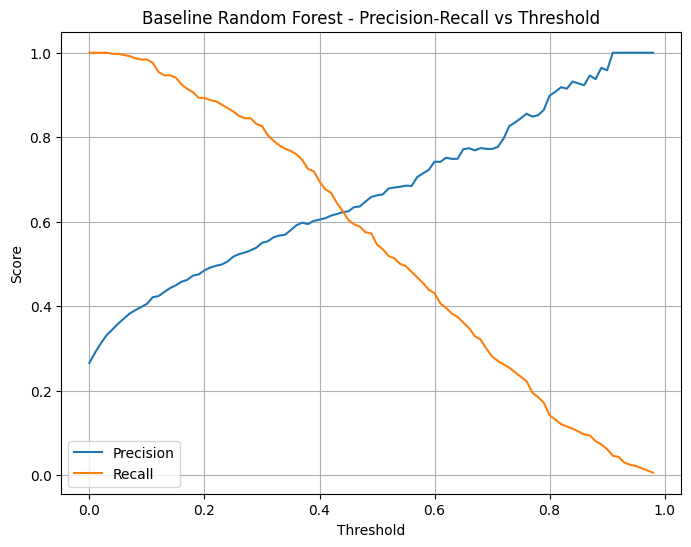


 best threshold (max F1): 0.360

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1035
           1       0.59      0.76      0.67       374

    accuracy                           0.80      1409
   macro avg       0.75      0.78      0.76      1409
weighted avg       0.82      0.80      0.80      1409

ROC-AUC Score: 0.8683


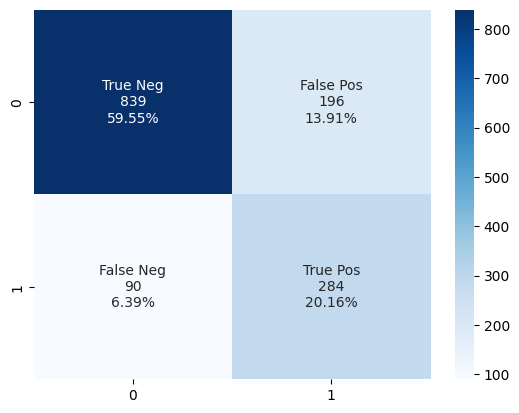

In [46]:
y_prob = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Baseline Random Forest - Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Select threshold based on max F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n best threshold (max F1): {best_threshold:.3f}")

y_pred = (y_prob >= best_threshold).astype(int)

c_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in c_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]

labels = [f"{g1}\n{g2}\n{g3}" for g1, g2, g3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

While the results of this baseline Random Forest are more promising than the tuned Forest, the results are very similar to the baseline Logistic Regression model, with the same number of false negatives and same class 1 recall, but lower class 1 precision at 0.58 vs 0.60 and more false positives at 208 vs 196. It is a model to keep in consideration, but I feel better models may be available at this point in testing. We will now look at the third model I will be testing - Extreme Gradient Boosting (XGB):

In [52]:
model = XGBClassifier(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

param_grid = {
    'classifier__learning_rate': [.03, .04, 0.05, .06, .07, .08, .09, 0.1, .11],
    'classifier__max_depth': [3, 4, 5, 7, 8, 9],
    'classifier__min_child_weight': [1, 2, 3, 4, 5, 6, 7]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='recall',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 378 candidates, totalling 1890 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Tenure '
                                                                          'Months',
                                                                          'Monthly '
                                                                          'Charges',
                                                                          'Total '
                                                                          'Charges',
                                                                          'CLTV',
                                                                          'Number '
                                                                          'of '
                                                                          'Dependents',
                                                                          'Age',
                                                                          'Number '
                                                                          'of '
                                                                          'Referrals',
                                                                          'Avg '
                                                                          'Monthly '
                                                                          'Long '
                                                                          'Distance '
                                                                          'Charges',
                                                                          'Avg '
                                                                          'Monthly '
                                                                          'GB '
                                                                          'Download',
                                                                          'Total '
                                                                          'Refunds',
                                                                          'Total '
                                                                          'Extra '
                                                                          'Data '
                                                                          'Charges',
                                                                          'T...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.03, 0.04, 0.05, 0.06,
                                                       0.07, 0.08, 0.09, 0.1,
                                                       0.11],
                         'classifier__max_depth': [3, 4, 5, 7, 8, 9],
                         'classifier__min_child_weight': [1, 2, 3, 4, 5, 6, 7]},
             scoring='recall', verbose=2)

In [53]:
print(f"\n Best parameters: {grid_search.best_params_}")
print(f" Best cross-validated score (recall): {grid_search.best_score_:.4f}")
cv_results = pd.DataFrame(grid_search.cv_results_)
print(cv_results[['params', 'mean_test_score', 'rank_test_score']])


 Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__min_child_weight': 4}
 Best cross-validated score (recall): 0.6475
                                                params  mean_test_score  \
0    {'classifier__learning_rate': 0.03, 'classifie...         0.567893   
1    {'classifier__learning_rate': 0.03, 'classifie...         0.570569   
2    {'classifier__learning_rate': 0.03, 'classifie...         0.567893   
3    {'classifier__learning_rate': 0.03, 'classifie...         0.569900   
4    {'classifier__learning_rate': 0.03, 'classifie...         0.569231   
..                                                 ...              ...   
373  {'classifier__learning_rate': 0.11, 'classifie...         0.622074   
374  {'classifier__learning_rate': 0.11, 'classifie...         0.636120   
375  {'classifier__learning_rate': 0.11, 'classifie...         0.626756   
376  {'classifier__learning_rate': 0.11, 'classifie...         0.623411   
377  {'classi

In [54]:
model = XGBClassifier(learning_rate=0.1, max_depth=7, min_child_weight=4, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges', 'CLTV',
                                                   'Number of Dependents',
                                                   'Age', 'Number of Referrals',
                                                   'Avg Monthly Long Distance '
                                                   'Charges',
                                                   'Avg Monthly GB Download',
                                                   'Total Refunds',
                                                   'Total Extra Data Charges',
                                                   'Total Long Distance '
                                                   'Charges',
                                                   'Total Revenue',
                                                   'Log_Total_Revenue',...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None, min_child_weight=4,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None, ...))])

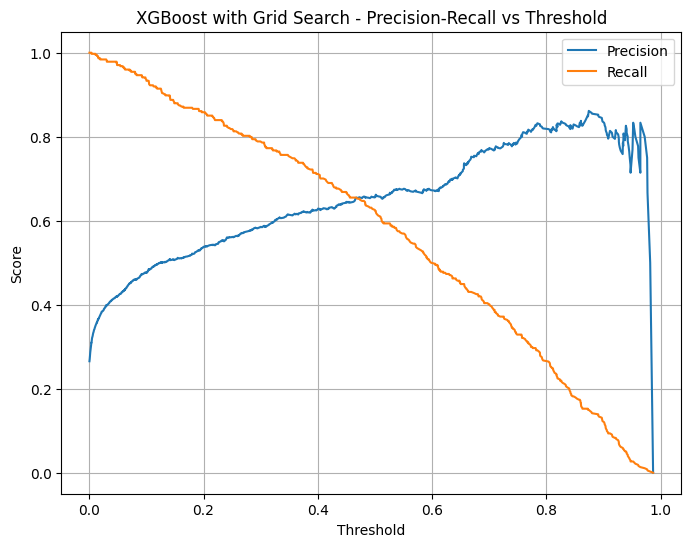


 best threshold (max F1): 0.348

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1035
           1       0.62      0.76      0.68       374

    accuracy                           0.81      1409
   macro avg       0.76      0.79      0.77      1409
weighted avg       0.83      0.81      0.82      1409

ROC-AUC Score: 0.8758


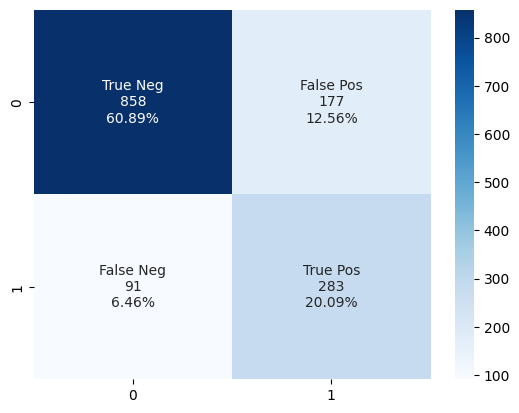

In [55]:
y_prob = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('XGBoost with Grid Search - Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Select threshold based on max F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n best threshold (max F1): {best_threshold:.3f}")

y_pred = (y_prob >= best_threshold).astype(int)

c_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in c_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]

labels = [f"{g1}\n{g2}\n{g3}" for g1, g2, g3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Based on the results, this is the best performing model so far in terms of metrics. 78 false negatives is 4 fewer than the least number of false negatives so far (82 with baseline LR and baseline RF). It's tied with tuned Logistic Regression for the highest class 1 precision at 0.62, and has the highest class 1 recall so far at 0.79. It also has the second highest ROC-AUC score of the models ran so far, at 0.8828, just behind the ROC-AUC of tuned Logistic Regression at 0.8848. However, while the model's metrics are slightly better than tuned Logistic Regression, it is also severely more computationally expensive, taking significantly longer to run than LR. Taking that into account, I would place tuned XGB in second behind tuned LR. Let's see how it compares to baseline XGB before moving on to the fourth and final algorithm I'll be testing, followed by SMOTENC incorporation. 

In [56]:
model = XGBClassifier(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges', 'CLTV',
                                                   'Number of Dependents',
                                                   'Age', 'Number of Referrals',
                                                   'Avg Monthly Long Distance '
                                                   'Charges',
                                                   'Avg Monthly GB Download',
                                                   'Total Refunds',
                                                   'Total Extra Data Charges',
                                                   'Total Long Distance '
                                                   'Charges',
                                                   'Total Revenue',
                                                   'Log_Total_Revenue',...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

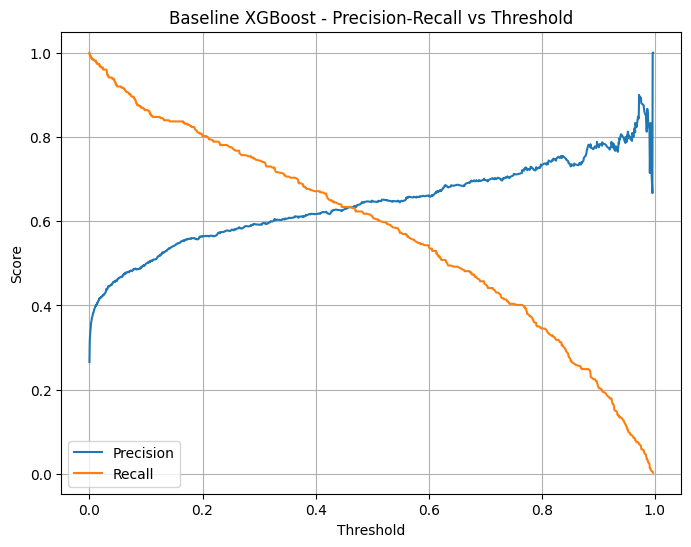


 best threshold (max F1): 0.180

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1035
           1       0.56      0.83      0.67       374

    accuracy                           0.78      1409
   macro avg       0.74      0.80      0.75      1409
weighted avg       0.83      0.78      0.79      1409

ROC-AUC Score: 0.8639


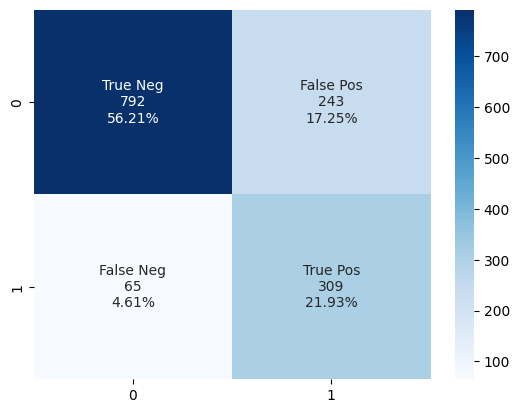

In [57]:
y_prob = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Baseline XGBoost - Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Select threshold based on max F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n best threshold (max F1): {best_threshold:.3f}")

y_pred = (y_prob >= best_threshold).astype(int)

c_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in c_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]

labels = [f"{g1}\n{g2}\n{g3}" for g1, g2, g3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Looking at the results, the tuned XGB performs much better than the baseline, therefore, this model will not be given much consideration. We will then move on to our last model, the Support Vector Classification (SVC).

In [60]:
model = svm.SVC(probability=True, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

param_grid = {
    'classifier__C': [1, 2, 3, 4, 5, 7]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='recall',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Tenure '
                                                                          'Months',
                                                                          'Monthly '
                                                                          'Charges',
                                                                          'Total '
                                                                          'Charges',
                                                                          'CLTV',
                                                                          'Number '
                                                                          'of '
                                                                          'Dependents',
                                                                          'Age',
                                                                          'Number '
                                                                          'of '
                                                                          'Referrals',
                                                                          'Avg '
                                                                          'Monthly '
                                                                          'Long '
                                                                          'Distance '
                                                                          'Charges',
                                                                          'Avg '
                                                                          'Monthly '
                                                                          'GB '
                                                                          'Download',
                                                                          'Total '
                                                                          'Refunds',
                                                                          'Total '
                                                                          'Extra '
                                                                          'Data '
                                                                          'Charges',
                                                                          'T...
                                                                          'Dependents',
                                                                          'Unlimited '
                                                                          'Data',
                                                                          'Streaming '
                                                                          'Movies',
                                                                          'Streaming '
                                                                          'TV',
                                                                          'Referred '
                                                                          'a '
                                                                          'Friend',
                                                                          'Paperless '
                                                                          'Billing',
                                                                          'Device '
                                                                          'Protection',
                                                              

In [61]:
print(f"\n Best parameters: {grid_search.best_params_}")
print(f" Best cross-validated score (recall): {grid_search.best_score_:.4f}")
cv_results = pd.DataFrame(grid_search.cv_results_)
print(cv_results[['params', 'mean_test_score', 'rank_test_score']])


 Best parameters: {'classifier__C': 3}
 Best cross-validated score (recall): 0.6181
                 params  mean_test_score  rank_test_score
0  {'classifier__C': 1}         0.595318                6
1  {'classifier__C': 2}         0.605351                5
2  {'classifier__C': 3}         0.618060                1
3  {'classifier__C': 4}         0.616722                2
4  {'classifier__C': 5}         0.615385                3
5  {'classifier__C': 7}         0.606689                4


In [62]:
model = svm.SVC(C=3, probability=True, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges', 'CLTV',
                                                   'Number of Dependents',
                                                   'Age', 'Number of Referrals',
                                                   'Avg Monthly Long Distance '
                                                   'Charges',
                                                   'Avg Monthly GB Download',
                                                   'Total Refunds',
                                                   'Total Extra Data Charges',
                                                   'Total Long Distance '
                                                   'Charges',
                                                   'Total Revenue',
                                                   'Log_Total_Revenue',...
                                                  ['Gender', 'Senior Citizen',
                                                   'Offer', 'Payment Method',
                                                   'Contract',
                                                   'Premium Tech Support',
                                                   'Online Security',
                                                   'Internet Service',
                                                   'Dependents',
                                                   'Unlimited Data',
                                                   'Streaming Movies',
                                                   'Streaming TV',
                                                   'Referred a Friend',
                                                   'Paperless Billing',
                                                   'Device Protection',
                                                   'Online Backup', 'Partner',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Streaming Music'])])),
                ('classifier', SVC(C=3, probability=True, random_state=42))])

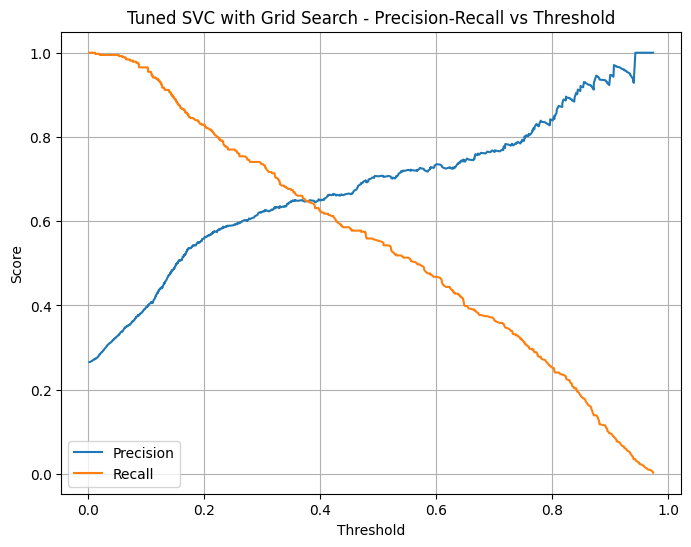


 best threshold (max F1): 0.296

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      1035
           1       0.62      0.74      0.68       374

    accuracy                           0.81      1409
   macro avg       0.76      0.79      0.77      1409
weighted avg       0.83      0.81      0.82      1409

ROC-AUC Score: 0.8691


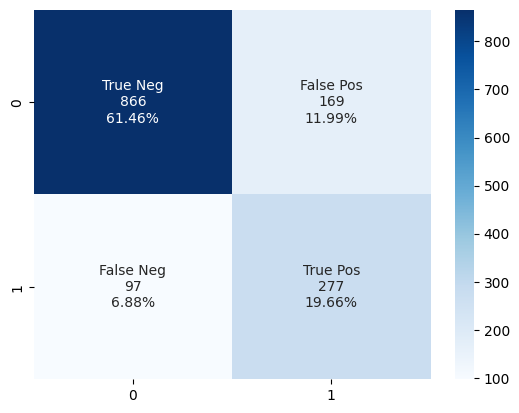

In [63]:
y_prob = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Tuned SVC with Grid Search - Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Select threshold based on max F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n best threshold (max F1): {best_threshold:.3f}")

y_pred = (y_prob >= best_threshold).astype(int)

c_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in c_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]

labels = [f"{g1}\n{g2}\n{g3}" for g1, g2, g3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Looking at the results of the SVC, the model performs particularly well on the negative class, with the highest number of true negatives and lowest number of false positives so far. However, its performance on the positive class is not as good as previous models, finding 96 false negatives, and scoring a class 1 recall score of 0.74. Additionally, it's the most computationally expensive model thus far. While it could be looked at as a better balance of class 1 recall and precision than other models, for my goals, I would like it to classify fewer false negatives and run faster. We will compare the results to a baseline SVC model.

In [64]:
model = svm.SVC(probability=True, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges', 'CLTV',
                                                   'Number of Dependents',
                                                   'Age', 'Number of Referrals',
                                                   'Avg Monthly Long Distance '
                                                   'Charges',
                                                   'Avg Monthly GB Download',
                                                   'Total Refunds',
                                                   'Total Extra Data Charges',
                                                   'Total Long Distance '
                                                   'Charges',
                                                   'Total Revenue',
                                                   'Log_Total_Revenue',...
                                                  ['Gender', 'Senior Citizen',
                                                   'Offer', 'Payment Method',
                                                   'Contract',
                                                   'Premium Tech Support',
                                                   'Online Security',
                                                   'Internet Service',
                                                   'Dependents',
                                                   'Unlimited Data',
                                                   'Streaming Movies',
                                                   'Streaming TV',
                                                   'Referred a Friend',
                                                   'Paperless Billing',
                                                   'Device Protection',
                                                   'Online Backup', 'Partner',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Streaming Music'])])),
                ('classifier', SVC(probability=True, random_state=42))])

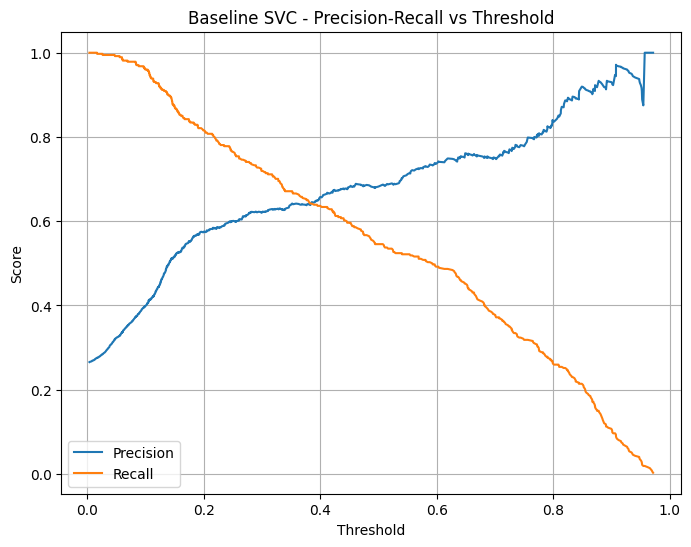


 best threshold (max F1): 0.216

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1035
           1       0.58      0.80      0.68       374

    accuracy                           0.80      1409
   macro avg       0.75      0.80      0.76      1409
weighted avg       0.83      0.80      0.81      1409

ROC-AUC Score: 0.8703


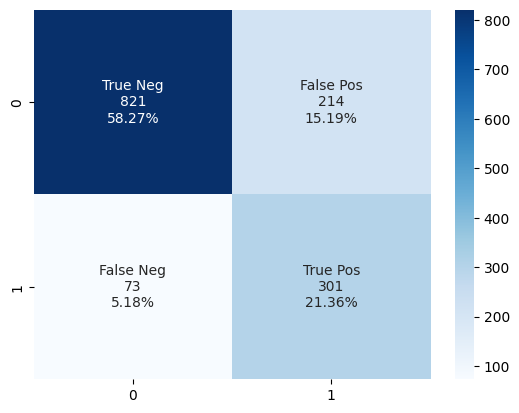

In [65]:
y_prob = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Baseline SVC - Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Select threshold based on max F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n best threshold (max F1): {best_threshold:.3f}")

y_pred = (y_prob >= best_threshold).astype(int)

c_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in c_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]

labels = [f"{g1}\n{g2}\n{g3}" for g1, g2, g3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

The baseline SVC performs better than the tuned version for my goals, classifying fewer false negatives, scoring a higher class 1 recall at 0.76 vs 0.74, and still maintains a relatively low number of false positives compared to other models at 173. This model could definitely be in consideration to be the chosen model, however its computational expense makes me still lean towards the tuned XGB and the LR models. 

Now that I've ran and evaluated the baseline and tuned versions of my chosen models, I will now evaluate the tuned models after using SMOTENC on the dataset. SMOTENC will be used to oversample the minority class (churners - 1), in order to deal with the class imbalance in the data. SMOTENC will be used in particular over SMOTE so that both the categorical and numerical variables can be used.

In [66]:
smotenc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_resampled, y_resampled = smotenc.fit_resample(X_train, y_train)

print(f"\nClass distribution after SMOTENC resampling:\n{pd.Series(y_resampled).value_counts()}")


Class distribution after SMOTENC resampling:
Churn Value
0    4139
1    4139
Name: count, dtype: int64


We can see now that the resampled data has an even number of churners and non-churners to test with. Moving forward with this, we will now test and evaluate our tuned models, and rerun grid search to determine if the optimal hyperparameters for the models have changed as a result the new, balanced data. We will start with Logistic Regression:

In [86]:
model = LogisticRegression(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

param_grid = {
    'classifier__solver': ['liblinear', 'sag', 'saga'],
    'classifier__max_iter': [7, 8, 9, 10, 15, 20],
    'classifier__C': [.005, .01, .015, .02, .03, .05]   
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='recall',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Tenure '
                                                                          'Months',
                                                                          'Monthly '
                                                                          'Charges',
                                                                          'Total '
                                                                          'Charges',
                                                                          'CLTV',
                                                                          'Number '
                                                                          'of '
                                                                          'Dependents',
                                                                          'Age',
                                                                          'Number '
                                                                          'of '
                                                                          'Referrals',
                                                                          'Avg '
                                                                          'Monthly '
                                                                          'Long '
                                                                          'Distance '
                                                                          'Charges',
                                                                          'Avg '
                                                                          'Monthly '
                                                                          'GB '
                                                                          'Download',
                                                                          'Total '
                                                                          'Refunds',
                                                                          'Total '
                                                                          'Extra '
                                                                          'Data '
                                                                          'Charges',
                                                                          'T...
                                                                          'Billing',
                                                                          'Device '
                                                                          'Protection',
                                                                          'Online '
                                                                          'Backup',
                                                                          'Partner',
                                                                          'Phone '
                                                                          'Service',
                                                                          'Multiple '
                                                                          'Lines',
                                                                          'Streaming '
                                                                          'Music'])])),
                                       ('classifier',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.005, 0.01, 0.015, 0.02, 0

In [87]:
print(f"\n Best parameters: {grid_search.best_params_}")
print(f" Best cross-validated score (recall): {grid_search.best_score_:.4f}")
cv_results = pd.DataFrame(grid_search.cv_results_)
print(cv_results[['params', 'mean_test_score', 'rank_test_score']])


 Best parameters: {'classifier__C': 0.02, 'classifier__max_iter': 7, 'classifier__solver': 'liblinear'}
 Best cross-validated score (recall): 0.8746
                                                params  mean_test_score  \
0    {'classifier__C': 0.005, 'classifier__max_iter...         0.870276   
1    {'classifier__C': 0.005, 'classifier__max_iter...         0.864479   
2    {'classifier__C': 0.005, 'classifier__max_iter...         0.866412   
3    {'classifier__C': 0.005, 'classifier__max_iter...         0.870276   
4    {'classifier__C': 0.005, 'classifier__max_iter...         0.865203   
..                                                 ...              ...   
103  {'classifier__C': 0.05, 'classifier__max_iter'...         0.870760   
104  {'classifier__C': 0.05, 'classifier__max_iter'...         0.871726   
105  {'classifier__C': 0.05, 'classifier__max_iter'...         0.872209   
106  {'classifier__C': 0.05, 'classifier__max_iter'...         0.870760   
107  {'classifier__C': 0.

In [88]:
model = LogisticRegression(C=.02, solver='liblinear', max_iter=7, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_resampled, y_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges', 'CLTV',
                                                   'Number of Dependents',
                                                   'Age', 'Number of Referrals',
                                                   'Avg Monthly Long Distance '
                                                   'Charges',
                                                   'Avg Monthly GB Download',
                                                   'Total Refunds',
                                                   'Total Extra Data Charges',
                                                   'Total Long Distance '
                                                   'Charges',
                                                   'Total Revenue',
                                                   'Log_Total_Revenue',...
                                                   'Contract',
                                                   'Premium Tech Support',
                                                   'Online Security',
                                                   'Internet Service',
                                                   'Dependents',
                                                   'Unlimited Data',
                                                   'Streaming Movies',
                                                   'Streaming TV',
                                                   'Referred a Friend',
                                                   'Paperless Billing',
                                                   'Device Protection',
                                                   'Online Backup', 'Partner',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Streaming Music'])])),
                ('classifier',
                 LogisticRegression(C=0.02, max_iter=7, random_state=42,
                                    solver='liblinear'))])

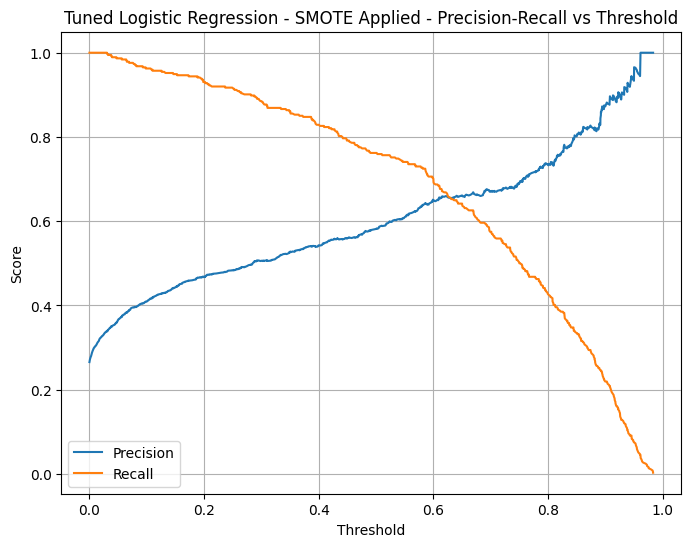


 best threshold (max F1): 0.586

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      1035
           1       0.64      0.72      0.68       374

    accuracy                           0.82      1409
   macro avg       0.77      0.79      0.78      1409
weighted avg       0.83      0.82      0.82      1409

ROC-AUC Score: 0.8740


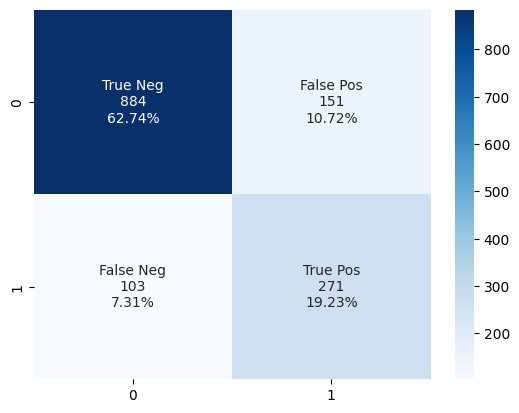

In [89]:
y_prob = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Tuned Logistic Regression - SMOTE Applied - Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Select threshold based on max F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n best threshold (max F1): {best_threshold:.3f}")

y_pred = (y_prob >= best_threshold).astype(int)

c_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in c_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]

labels = [f"{g1}\n{g2}\n{g3}" for g1, g2, g3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Based on the results, this is the best performing model so far in terms of our desired metrics. 61 false negatives is very low, with a class 1 recall score of 0.84 and a ROC-AUC of 0.8815. Conversely, there is also a high number of false positives at 227, so we would need to evaluate if giving up that many false positives in order to have that few of false negatives makes sense for a profit standpoint. We're assuming of course, that retention costs are less than the cost of a lost customer + replacing one, however, paying too much in unnecessary customer retention cost could end up defeating the purpose. I do like this model from a metric standpoint and a computational cost standpoint, and the threshold could be moved in order to have fewer false positives at the cost of some false negatives if necessary. I will wait to evaluate the other three models before committing to this. 

In [101]:
model = RandomForestClassifier(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

param_grid = {
    'classifier__n_estimators': [83, 84, 85, 86, 87, 88, 89, 90],
    'classifier__criterion': ['gini', 'log_loss', 'entropy'],
    'classifier__max_depth': [1, 2, 5, 10, 50, 60, 80]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='recall',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Tenure '
                                                                          'Months',
                                                                          'Monthly '
                                                                          'Charges',
                                                                          'Total '
                                                                          'Charges',
                                                                          'CLTV',
                                                                          'Number '
                                                                          'of '
                                                                          'Dependents',
                                                                          'Age',
                                                                          'Number '
                                                                          'of '
                                                                          'Referrals',
                                                                          'Avg '
                                                                          'Monthly '
                                                                          'Long '
                                                                          'Distance '
                                                                          'Charges',
                                                                          'Avg '
                                                                          'Monthly '
                                                                          'GB '
                                                                          'Download',
                                                                          'Total '
                                                                          'Refunds',
                                                                          'Total '
                                                                          'Extra '
                                                                          'Data '
                                                                          'Charges',
                                                                          'T...
                                                                          'Protection',
                                                                          'Online '
                                                                          'Backup',
                                                                          'Partner',
                                                                          'Phone '
                                                                          'Service',
                                                                          'Multiple '
                                                                          'Lines',
                                                                          'Streaming '
                                                                          'Music'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'log_loss',
                                                   'entropy'],
                         'classifier__max_depth': [1, 2, 5, 10, 50, 60, 80],
                        

In [102]:
print(f"\n Best parameters: {grid_search.best_params_}")
print(f" Best cross-validated score (recall): {grid_search.best_score_:.4f}")
cv_results = pd.DataFrame(grid_search.cv_results_)
print(cv_results[['params', 'mean_test_score', 'rank_test_score']])


 Best parameters: {'classifier__criterion': 'log_loss', 'classifier__max_depth': 1, 'classifier__n_estimators': 86}
 Best cross-validated score (recall): 0.8927
                                                params  mean_test_score  \
0    {'classifier__criterion': 'gini', 'classifier_...         0.891534   
1    {'classifier__criterion': 'gini', 'classifier_...         0.891534   
2    {'classifier__criterion': 'gini', 'classifier_...         0.891051   
3    {'classifier__criterion': 'gini', 'classifier_...         0.892259   
4    {'classifier__criterion': 'gini', 'classifier_...         0.890568   
..                                                 ...              ...   
163  {'classifier__criterion': 'entropy', 'classifi...         0.871495   
164  {'classifier__criterion': 'entropy', 'classifi...         0.874635   
165  {'classifier__criterion': 'entropy', 'classifi...         0.872219   
166  {'classifier__criterion': 'entropy', 'classifi...         0.873669   
167  {'classi

In [103]:
model = RandomForestClassifier(criterion='log_loss', n_estimators=86, max_depth=1, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_resampled, y_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges', 'CLTV',
                                                   'Number of Dependents',
                                                   'Age', 'Number of Referrals',
                                                   'Avg Monthly Long Distance '
                                                   'Charges',
                                                   'Avg Monthly GB Download',
                                                   'Total Refunds',
                                                   'Total Extra Data Charges',
                                                   'Total Long Distance '
                                                   'Charges',
                                                   'Total Revenue',
                                                   'Log_Total_Revenue',...
                                                   'Premium Tech Support',
                                                   'Online Security',
                                                   'Internet Service',
                                                   'Dependents',
                                                   'Unlimited Data',
                                                   'Streaming Movies',
                                                   'Streaming TV',
                                                   'Referred a Friend',
                                                   'Paperless Billing',
                                                   'Device Protection',
                                                   'Online Backup', 'Partner',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Streaming Music'])])),
                ('classifier',
                 RandomForestClassifier(criterion='log_loss', max_depth=1,
                                        n_estimators=86, random_state=42))])

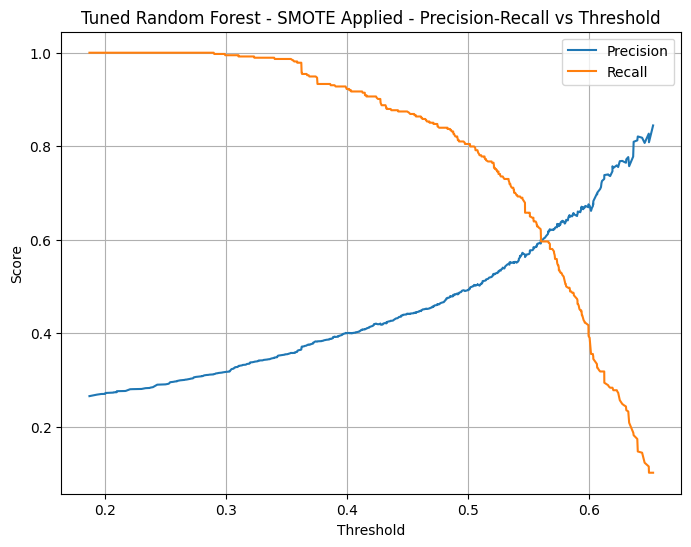


 best threshold (max F1): 0.534

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1035
           1       0.55      0.73      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409

ROC-AUC Score: 0.8340


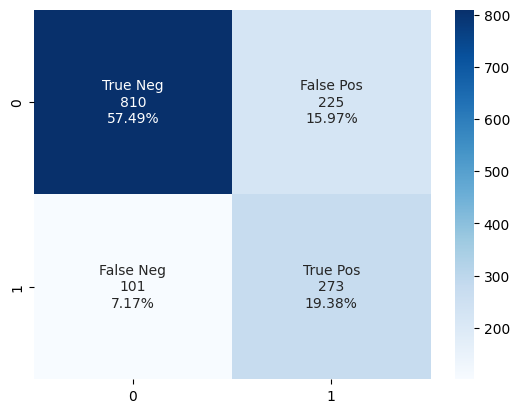

In [104]:
y_prob = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Tuned Random Forest - SMOTE Applied - Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Select threshold based on max F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n best threshold (max F1): {best_threshold:.3f}")

y_pred = (y_prob >= best_threshold).astype(int)

c_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in c_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]

labels = [f"{g1}\n{g2}\n{g3}" for g1, g2, g3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

This Random Forest model gives up too many false negatives, and has much too low of an ROC-AUC compared to the other models to be considered. The baseline RF model ran the best out of the three RF models tested.

In [109]:
model = XGBClassifier(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

param_grid = {
    'classifier__learning_rate': [.0005, 0.001, .002, .003, 0.005, 0.01],
    'classifier__max_depth': [2, 3, 4, 5, 6, 7],
    'classifier__min_child_weight': [1, 2, 3, 4]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='recall',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Tenure '
                                                                          'Months',
                                                                          'Monthly '
                                                                          'Charges',
                                                                          'Total '
                                                                          'Charges',
                                                                          'CLTV',
                                                                          'Number '
                                                                          'of '
                                                                          'Dependents',
                                                                          'Age',
                                                                          'Number '
                                                                          'of '
                                                                          'Referrals',
                                                                          'Avg '
                                                                          'Monthly '
                                                                          'Long '
                                                                          'Distance '
                                                                          'Charges',
                                                                          'Avg '
                                                                          'Monthly '
                                                                          'GB '
                                                                          'Download',
                                                                          'Total '
                                                                          'Refunds',
                                                                          'Total '
                                                                          'Extra '
                                                                          'Data '
                                                                          'Charges',
                                                                          'T...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.0005, 0.001, 0.002,
                                                       0.003, 0.005, 0.01],
                         'classifier__max_depth': [2, 3, 4, 5, 6, 7],
                         'classifier__min_child_weight': [1, 2, 3, 4]},
             scoring='recall', verbose=2)

In [110]:
print(f"\n Best parameters: {grid_search.best_params_}")
print(f" Best cross-validated score (recall): {grid_search.best_score_:.4f}")
cv_results = pd.DataFrame(grid_search.cv_results_)
print(cv_results[['params', 'mean_test_score', 'rank_test_score']])


 Best parameters: {'classifier__learning_rate': 0.001, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1}
 Best cross-validated score (recall): 0.8990
                                                params  mean_test_score  \
0    {'classifier__learning_rate': 0.0005, 'classif...         0.890079   
1    {'classifier__learning_rate': 0.0005, 'classif...         0.890079   
2    {'classifier__learning_rate': 0.0005, 'classif...         0.890079   
3    {'classifier__learning_rate': 0.0005, 'classif...         0.890079   
4    {'classifier__learning_rate': 0.0005, 'classif...         0.840073   
..                                                 ...              ...   
139  {'classifier__learning_rate': 0.01, 'classifie...         0.892261   
140  {'classifier__learning_rate': 0.01, 'classifie...         0.889124   
141  {'classifier__learning_rate': 0.01, 'classifie...         0.889364   
142  {'classifier__learning_rate': 0.01, 'classifie...         0.888157   
143  {'clas

In [111]:
model = XGBClassifier(learning_rate=0.001, max_depth=5, min_child_weight=1, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_resampled, y_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges', 'CLTV',
                                                   'Number of Dependents',
                                                   'Age', 'Number of Referrals',
                                                   'Avg Monthly Long Distance '
                                                   'Charges',
                                                   'Avg Monthly GB Download',
                                                   'Total Refunds',
                                                   'Total Extra Data Charges',
                                                   'Total Long Distance '
                                                   'Charges',
                                                   'Total Revenue',
                                                   'Log_Total_Revenue',...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.001, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

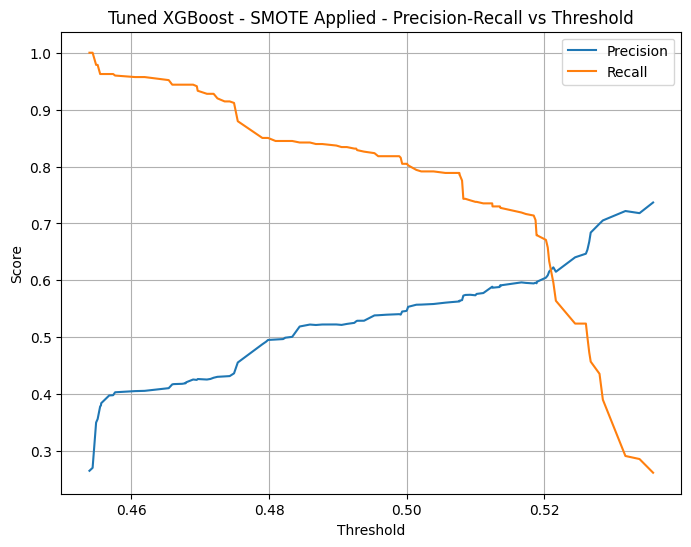


 best threshold (max F1): 0.508

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1035
           1       0.56      0.79      0.66       374

    accuracy                           0.78      1409
   macro avg       0.74      0.78      0.75      1409
weighted avg       0.82      0.78      0.79      1409

ROC-AUC Score: 0.8472


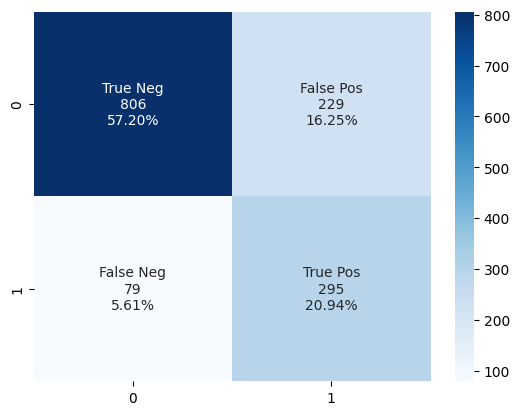

In [112]:
y_prob = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Tuned XGBoost - SMOTE Applied - Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Select threshold based on max F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n best threshold (max F1): {best_threshold:.3f}")

y_pred = (y_prob >= best_threshold).astype(int)

c_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in c_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]

labels = [f"{g1}\n{g2}\n{g3}" for g1, g2, g3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

The tuned XGB model with SMOTENC applied performs worse than its non SMOTENC applied, tuned counterpart, receiving the same number of false negatives and true positives, but classifying 36 fewer true negatives and 36 greater false positives. The ROC-AUC score is also lower at .8690 vs .8828. This model will not be considered.

In [113]:
model = svm.SVC(probability=True, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

param_grid = {
    'classifier__C': [1, 2, 3, 4, 5, 6]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='recall',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Tenure '
                                                                          'Months',
                                                                          'Monthly '
                                                                          'Charges',
                                                                          'Total '
                                                                          'Charges',
                                                                          'CLTV',
                                                                          'Number '
                                                                          'of '
                                                                          'Dependents',
                                                                          'Age',
                                                                          'Number '
                                                                          'of '
                                                                          'Referrals',
                                                                          'Avg '
                                                                          'Monthly '
                                                                          'Long '
                                                                          'Distance '
                                                                          'Charges',
                                                                          'Avg '
                                                                          'Monthly '
                                                                          'GB '
                                                                          'Download',
                                                                          'Total '
                                                                          'Refunds',
                                                                          'Total '
                                                                          'Extra '
                                                                          'Data '
                                                                          'Charges',
                                                                          'T...
                                                                          'Dependents',
                                                                          'Unlimited '
                                                                          'Data',
                                                                          'Streaming '
                                                                          'Movies',
                                                                          'Streaming '
                                                                          'TV',
                                                                          'Referred '
                                                                          'a '
                                                                          'Friend',
                                                                          'Paperless '
                                                                          'Billing',
                                                                          'Device '
                                                                          'Protection',
                                                              

In [114]:
print(f"\n Best parameters: {grid_search.best_params_}")
print(f" Best cross-validated score (recall): {grid_search.best_score_:.4f}")
cv_results = pd.DataFrame(grid_search.cv_results_)
print(cv_results[['params', 'mean_test_score', 'rank_test_score']])


 Best parameters: {'classifier__C': 5}
 Best cross-validated score (recall): 0.8725
                 params  mean_test_score  rank_test_score
0  {'classifier__C': 1}         0.870767                5
1  {'classifier__C': 2}         0.870768                4
2  {'classifier__C': 3}         0.871010                3
3  {'classifier__C': 4}         0.870527                6
4  {'classifier__C': 5}         0.872460                1
5  {'classifier__C': 6}         0.872459                2


In [115]:
model = svm.SVC(C=5, probability=True, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_resampled, y_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges', 'CLTV',
                                                   'Number of Dependents',
                                                   'Age', 'Number of Referrals',
                                                   'Avg Monthly Long Distance '
                                                   'Charges',
                                                   'Avg Monthly GB Download',
                                                   'Total Refunds',
                                                   'Total Extra Data Charges',
                                                   'Total Long Distance '
                                                   'Charges',
                                                   'Total Revenue',
                                                   'Log_Total_Revenue',...
                                                  ['Gender', 'Senior Citizen',
                                                   'Offer', 'Payment Method',
                                                   'Contract',
                                                   'Premium Tech Support',
                                                   'Online Security',
                                                   'Internet Service',
                                                   'Dependents',
                                                   'Unlimited Data',
                                                   'Streaming Movies',
                                                   'Streaming TV',
                                                   'Referred a Friend',
                                                   'Paperless Billing',
                                                   'Device Protection',
                                                   'Online Backup', 'Partner',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Streaming Music'])])),
                ('classifier', SVC(C=5, probability=True, random_state=42))])

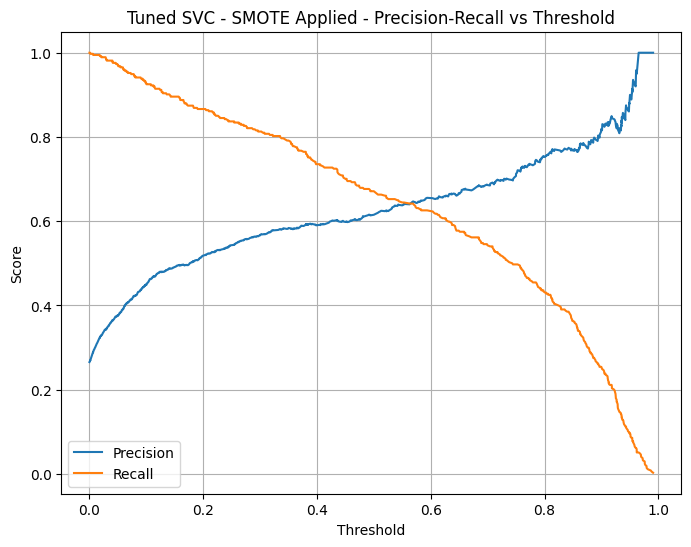


 best threshold (max F1): 0.335

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1035
           1       0.58      0.80      0.67       374

    accuracy                           0.79      1409
   macro avg       0.75      0.80      0.76      1409
weighted avg       0.83      0.79      0.80      1409

ROC-AUC Score: 0.8662


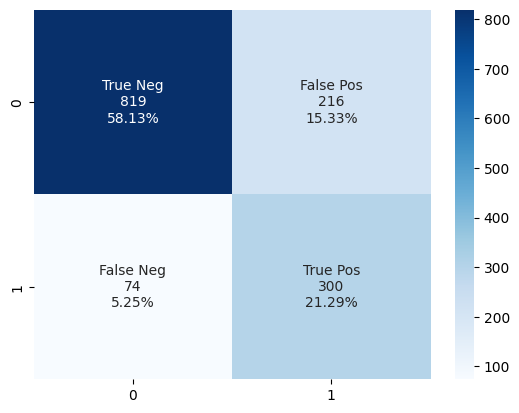

In [116]:
y_prob = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Tuned SVC - SMOTE Applied - Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Select threshold based on max F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n best threshold (max F1): {best_threshold:.3f}")

y_pred = (y_prob >= best_threshold).astype(int)

c_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in c_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]

labels = [f"{g1}\n{g2}\n{g3}" for g1, g2, g3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

This SVC model has the lowest ROC-AUC of the three, and classifies the most false negatives at 100. This model will not be considered.

I have recorded the results of each of my models into a pandas dataframe to visualize and compare for making my final decision on which model I will choose. The results are as follows:

In [47]:
model_results = pd.DataFrame({
    'Model': ['LR Baseline', 'RF Baseline', 'XGB Baseline', 'SVC Baseline', 'Tuned LR w/o SMOTENC', 'Tuned RF w/o SMOTENC', 'Tuned XGB w/o SMOTENC',
             'Tuned SVC w/o SMOTENC', 'Tuned LR with SMOTENC', 'Tuned RF with SMOTENC', 'Tuned XGB with SMOTENC', 'Tuned SVC with SMOTENC', 'AVERAGES'],
    'Precision (Class 0)': [.91, .91, .9, .91, .91, .9, .92, .9, .93, .89, .91, .9, .9075],
    'Recall (Class 0)': [.81, .8, .84, .83, .83, .81, .83, .85, .78, .83, .79, .85, .821],
    'f1-score (Class 0)': [.86, .85, .87, .87, .87, .85, .87, .87, .85, .86, .85, .87, .86167],
    'Precision (Class 1)': [.6, .58, .62, .62, .62, .59, .62, .64, .58, .61, .58, .63, .6075],
    'Recall (Class 1)': [.78, .78, .74, .76, .77, .75, .79, .74, .84, .73, .79, .73, .767],
    'f1-score (Class 1)': [.68, .67, .68, .69, .69, .66, .7, .69, .68, .66, .67, .68, .67917],
    'ROC-AUC': [.8786, .8681, .8691, .8811, .8848, .8661, .8828, .8808, .8815, .86, .869, .8802, .875175],
    'True Neg': [839, 827, 869, 862, 859, 840, 854, 879, 808, 858, 818, 876, 849.0833],
    'False Neg': [82, 82, 98, 89, 85, 94, 78, 96, 61, 102, 78, 100, 87.0833],
    'True Pos': [292, 292, 276, 285, 289, 280, 296, 278, 313, 272, 296, 274, 286.9167],
    'False Pos': [196, 208, 166, 173, 176, 195, 181, 156, 227, 177, 217, 159, 185.9167]
})

float_cols = model_results.select_dtypes(include='float').columns

(
    model_results.style 
    .format({col: "{:.4f}" for col in float_cols})     
    .set_table_styles([
        {'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', '#f0f0f0')]}
    ]) 
    .set_properties(**{
        'border': '1px solid black',
        'text-align': 'center',
        'background-color': '#fff'
    })
    .hide(axis="index")
)

Model,Precision (Class 0),Recall (Class 0),f1-score (Class 0),Precision (Class 1),Recall (Class 1),f1-score (Class 1),ROC-AUC,True Neg,False Neg,True Pos,False Pos
LR Baseline,0.9100,0.8100,0.8600,0.6000,0.7800,0.6800,0.8786,839.0000,82.0000,292.0000,196.0000
RF Baseline,0.9100,0.8000,0.8500,0.5800,0.7800,0.6700,0.8681,827.0000,82.0000,292.0000,208.0000
XGB Baseline,0.9000,0.8400,0.8700,0.6200,0.7400,0.6800,0.8691,869.0000,98.0000,276.0000,166.0000
SVC Baseline,0.9100,0.8300,0.8700,0.6200,0.7600,0.6900,0.8811,862.0000,89.0000,285.0000,173.0000
Tuned LR w/o SMOTENC,0.9100,0.8300,0.8700,0.6200,0.7700,0.6900,0.8848,859.0000,85.0000,289.0000,176.0000
Tuned RF w/o SMOTENC,0.9000,0.8100,0.8500,0.5900,0.7500,0.6600,0.8661,840.0000,94.0000,280.0000,195.0000
Tuned XGB w/o SMOTENC,0.9200,0.8300,0.8700,0.6200,0.7900,0.7000,0.8828,854.0000,78.0000,296.0000,181.0000
Tuned SVC w/o SMOTENC,0.9000,0.8500,0.8700,0.6400,0.7400,0.6900,0.8808,879.0000,96.0000,278.0000,156.0000
Tuned LR with SMOTENC,0.9300,0.7800,0.8500,0.5800,0.8400,0.6800,0.8815,808.0000,61.0000,313.0000,227.0000
Tuned RF with SMOTENC,0.8900,0.8300,0.8600,0.6100,0.7300,0.6600,0.8600,858.0000,102.0000,272.0000,177.0000


After considering the results of each model, I have decided that the model I will be moving forward with will be the Tuned Logistic Regression model with SMOTENC applied. From an interpretability standpoint, its results are the easiest to understand when compared to Random Forest, Extreme Gradient Boosting, and Scaled Vector Classifier, as the coefficients of the contributing feature variables have direct meaning. Each one represents the log-odds change in the odds of churn, provided the other variables hold constant. From a metrics standpoint, the model boasts the highest class 1 recall score of any of the models at 0.84, the third highest ROC-AUC score at 0.8815, and the fewest number of false negatives at only 61. This model also was tested with balanced data, albeit from SMOTENC. This leads me to believe it is more accurate and less biased than the Tuned LR model with the original class distribution. The high number of false positives will be something to monitor, and the threshold may be changed in order to lessen the number of false positives at the result of increased false negatives when determining what makes the most sense profit wise. Logistic Regression also has a lower computational cost than XGB and SVC, and comparable cost to Random Forest.  

In [119]:
def plot_feature_importance_detailed(pipeline, original_categorical_columns, original_numeric_columns, top_n=20):
    # Extract pipeline steps
    preprocessor = pipeline.named_steps['preprocessor']
    model = pipeline.named_steps['classifier']
    
    # Extract feature names
    numeric_features = original_numeric_columns
    ohe = preprocessor.named_transformers_['cat']
    categorical_features = list(ohe.get_feature_names_out(original_categorical_columns))
    all_features = numeric_features + categorical_features

    # Get coefficients
    coefficients = model.coef_.flatten()

    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': all_features,
        'Coefficient': coefficients,
        'Absolute Importance': np.abs(coefficients)
    }).sort_values(by='Absolute Importance', ascending=False).reset_index(drop=True)

    # Select top N
    top_df = importance_df.head(top_n).copy()
    top_df = top_df[::-1]  # Flip for better horizontal plotting

    # Plot
    plt.figure(figsize=(14, 10))
    bars = plt.barh(
        top_df['Feature'],
        top_df['Coefficient'],
        color=['red' if val > 0 else 'blue' for val in top_df['Coefficient']]
    )

    plt.axvline(0, color='black', linewidth=1)
    plt.xlabel("Coefficient Value", fontsize=12)
    plt.title(f"Top {top_n} Most Important Features (Positive = More Likely to Churn)", fontsize=14)
    plt.tight_layout()

    # Add coefficient values as labels
    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + 0.00001 * np.sign(width),  # Offset based on direction
            bar.get_y() + bar.get_height() / 2,
            f"{width:.2f}",
            va='center',
            ha='left' if width > 0 else 'right',
            fontsize=10,
            color='black'
        )

    plt.show()

    return importance_df

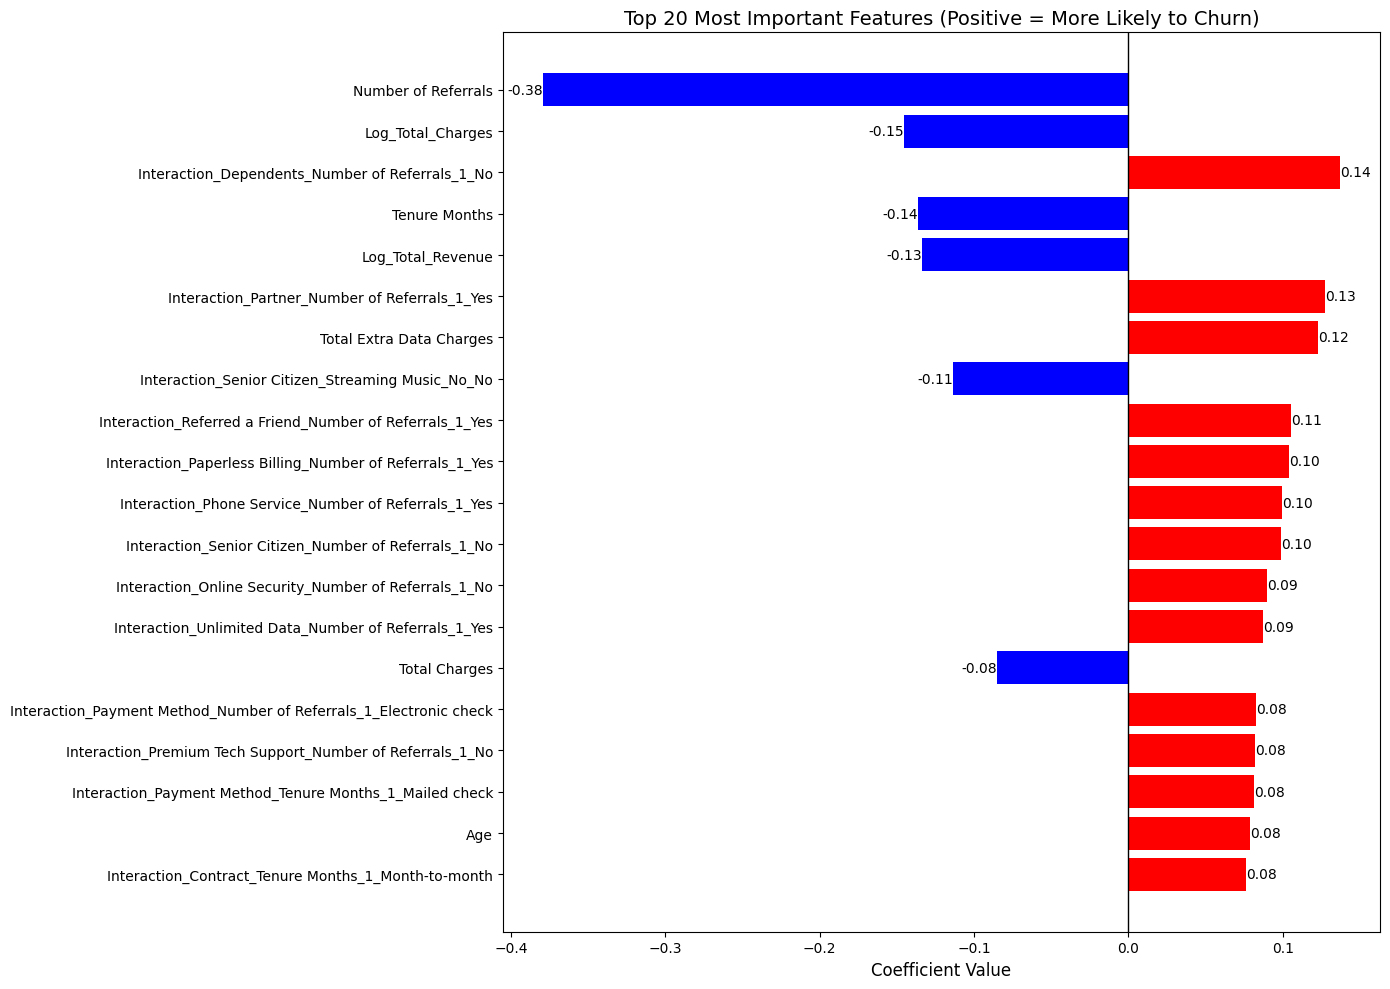

In [31]:
model = LogisticRegression(C=.005, solver='liblinear', max_iter=70, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_resampled, y_resampled)

importance_df = plot_feature_importance_detailed(pipeline, categorical_columns, numeric_columns, top_n=20)

Summarizing the graph results:

Churn-Reducing Signals:

Number of Referrals: -0.38 - Highly loyal customers - customers who refer others are significantly less likely to churn. Incentivizing referrals could improve retention.

Log_Total_Charges: -0.15 - Customers who have spent more historically are less likely to churn. Long-term revenue may indicate satisfaction or stickiness.

Tenure Months: -0.14 - The longer a customer has been with the company, the less likely they are to churn; classic retention inertia.

Log_Total_Revenue: -0.13 - High revenue customers (especially over time), are less prone to churn. These are your VIPs.

Interaction_Senior Citizen_Streaming Music_No_No: -0.11 - Older customers who use streaming music are likely more engaged - and less likely to churn. Engagement = retention.

Total Charges: -0.08 - Sinmilar to total revenue - more charges -> more investment -> more retention.

Takeaway: Retain your long-tenured, high-revenue, referral-generating customers - they are the core of your stable base.

Churn-Risk Indicators:



In [12]:
column_of_interest = 'Tenure Months'

value_counts = df[column_of_interest].value_counts()

print(value_counts)

Tenure Months
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64


In [120]:
model = LogisticRegression(C=0.05, solver='sag', max_iter=62, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges', 'CLTV',
                                                   'Number of Dependents',
                                                   'Age', 'Number of Referrals',
                                                   'Avg Monthly Long Distance '
                                                   'Charges',
                                                   'Avg Monthly GB Download',
                                                   'Total Refunds',
                                                   'Total Extra Data Charges',
                                                   'Total Long Distance '
                                                   'Charges',
                                                   'Total Revenue',
                                                   'Log_Total_Revenue',...
                                                   'Offer', 'Payment Method',
                                                   'Contract',
                                                   'Premium Tech Support',
                                                   'Online Security',
                                                   'Internet Service',
                                                   'Dependents',
                                                   'Unlimited Data',
                                                   'Streaming Movies',
                                                   'Streaming TV',
                                                   'Referred a Friend',
                                                   'Paperless Billing',
                                                   'Device Protection',
                                                   'Online Backup', 'Partner',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Streaming Music'])])),
                ('classifier',
                 LogisticRegression(C=0.05, max_iter=62, random_state=42,
                                    solver='sag'))])

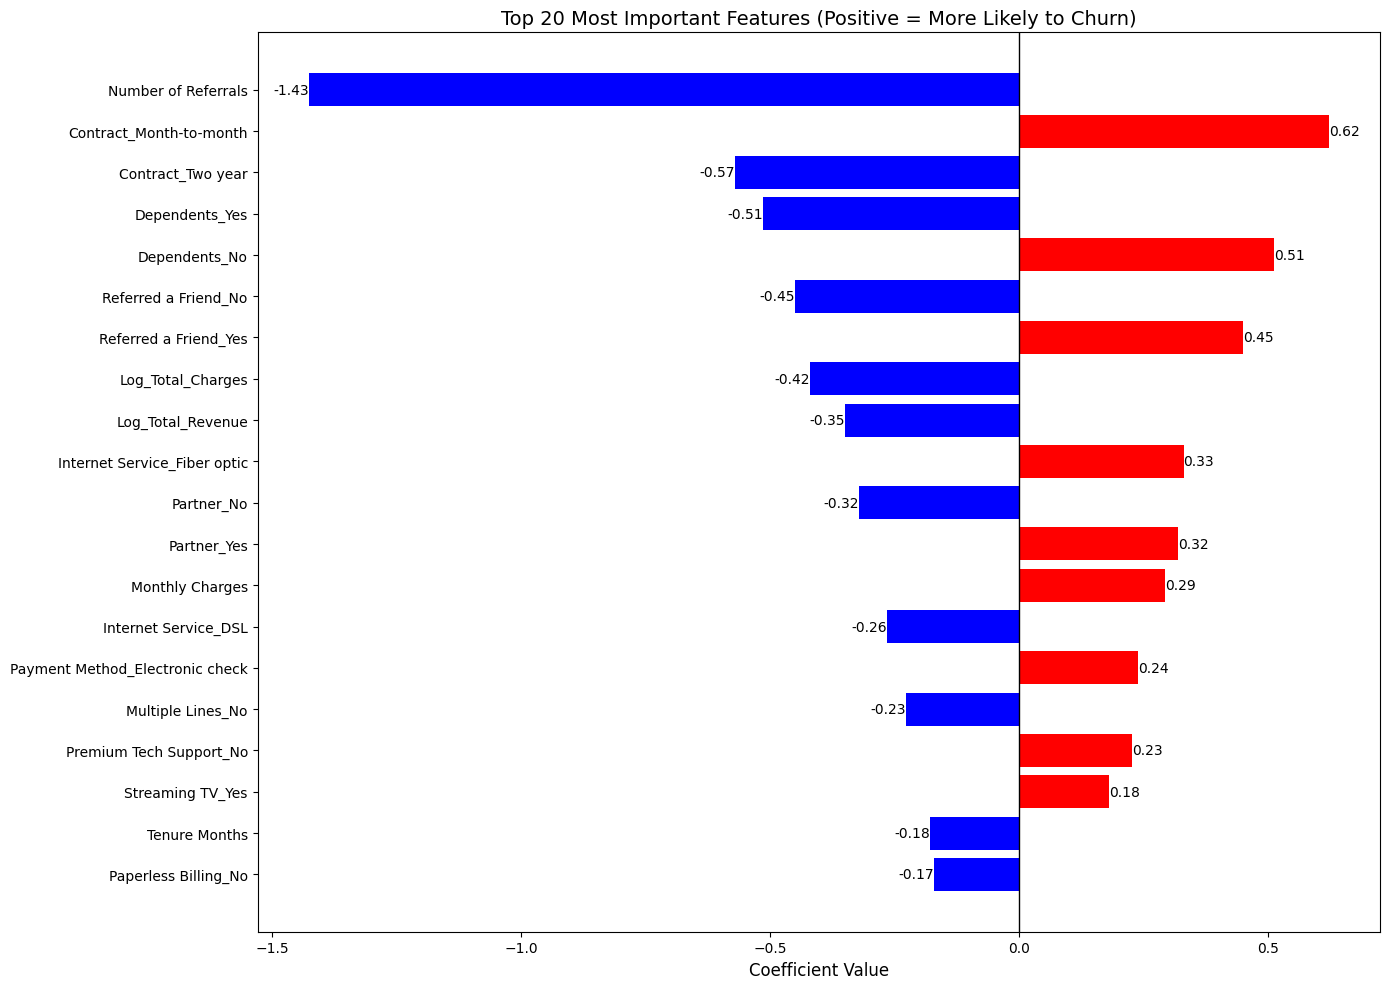

In [121]:
importance_df = plot_feature_importance_detailed(pipeline, original_categorical_columns, original_numeric_columns, top_n=20)